In [1]:
# imports

import pandas as pd
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

import numpy as np
import gc

import catboost ## thanks to yandex ! :) 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
# info about itertools.product: 
# https://pythonworld.ru/moduli/modul-itertools.html
# https://docs.python.org/2/library/itertools.html
from itertools import product

In [2]:
def cut_eff(x):
    if(x < 12000 or x > 20000):
        return 17000
    else:
        return x
    
def cut_qual(x):
    if(x > 3):
        return 2
    else:
        return x
    
def cut_energy(x):
    if(x < 15 or x > 30):
        return 23
    else:
        return x

# Работа с данными

Объеденим данные по месяцам:

In [3]:
eff_train = pd.read_csv('data/eff_train/eff_train1.csv', sep=';')
for x in range(2,11):
    eff_train_new = pd.read_csv('data/eff_train/eff_train{}.csv'.format(x), sep=';')
    eff_train = pd.concat([eff_train, eff_train_new])
eff_train = eff_train.rename(columns = {' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
eff_train.head(2)

,tag,timestamp,value,quality
0,Efficiency,01.10.2016 0:00,16137.70,Good
1,Efficiency,01.10.2016 0:00,16060.55,Good


In [4]:
eff_test1 = pd.read_csv('data/eff_test/eff_test1.csv', sep=';')
eff_test2 = pd.read_csv('data/eff_test/eff_test2.csv', sep=';')
eff_test = pd.concat([eff_test1, eff_test2])
eff_test = eff_test.rename(columns = {' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
eff_test.head(2)

,tag,timestamp,value,quality
0,Efficiency,01.08.2017 0:00,16836.91,Good
1,Efficiency,01.08.2017 0:00,17145.51,Good


In [5]:
energy_train = pd.read_csv('data/energy_cons_train/Energy_cons_train1.csv', sep=';')
for x in range(2,11):
    energy_train_new = pd.read_csv('data/energy_cons_train/Energy_cons_train{}.csv'.format(x), sep=';')
    energy_train = pd.concat([energy_train, energy_train_new])
energy_train = energy_train.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
energy_train.head(2)

,tag,timestamp,value,quality
0,Energy_cons,01.10.2016 0:01,20.347508,Good
1,Energy_cons,01.10.2016 0:02,20.24238,Good


In [6]:
energy_test = pd.read_csv('data/energy_cons_test/Energy_cons_test1.csv', sep=';')
x=2
energy_test_new = pd.read_csv('data/energy_cons_test/Energy_cons_test{}.csv'.format(x), sep=';')
energy_test = pd.concat([energy_test, energy_test_new])
energy_test = energy_test.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
energy_test.head(2)

,tag,timestamp,value,quality
0,Energy_cons,01.08.2017 0:01,17.324733,Good
1,Energy_cons,01.08.2017 0:02,17.46305,Good


In [7]:
qual_train = pd.read_csv('data/qual_train/qual_train1.csv', sep=';') 
for x in range(2,11): 
    qual_train_new = pd.read_csv('data/qual_train/qual_train{}.csv'.format(x), sep=';') 
    qual_train = pd.concat([qual_train, qual_train_new], ignore_index = True) 
qual_train = qual_train.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'}) 
qual_train.head(2)

,tag,timestamp,value,quality
0,Quality,01.10.2016 0:38,2.2,Good
1,Quality,01.10.2016 1:02,2.2,Good


In [8]:
qual_test = pd.read_csv('data/qual_test/qual_test1.csv', sep=';') 
x=2 
qual_test_new = pd.read_csv('data/qual_test/qual_test{}.csv'.format(x), sep=';') 
qual_test = pd.concat([qual_test, qual_test_new]) 
qual_test = qual_test.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'}) 
qual_test.head(2)

,tag,timestamp,value,quality
0,Quality,01.08.2017 0:14,2.2,Good
1,Quality,01.08.2017 0:38,2.2,Good


Объеденим трэйн и тест:

In [9]:
eff_all = pd.concat([eff_train, eff_test])
qual_all = pd.concat([qual_train, qual_test])
energy_all = pd.concat([energy_train, energy_test])

преобразуем колонку timestamp в тип datetime:

In [10]:
eff_all["timestamp"] = pd.to_datetime(eff_all["timestamp"], format = '%d.%m.%Y %H:%M')
qual_all["timestamp"] = pd.to_datetime(qual_all["timestamp"], format = '%d.%m.%Y %H:%M')
energy_all["timestamp"] = pd.to_datetime(energy_all["timestamp"], format = '%d.%m.%Y %H:%M')

In [11]:
eff_all.head(2)

,tag,timestamp,value,quality
0,Efficiency,2016-10-01,16137.70,Good
1,Efficiency,2016-10-01,16060.55,Good


In [12]:
qual_all.head(2)

,tag,timestamp,value,quality
0,Quality,2016-10-01 00:38:00,2.2,Good
1,Quality,2016-10-01 01:02:00,2.2,Good


In [13]:
energy_all.head()

,tag,timestamp,value,quality
0,Energy_cons,2016-10-01 00:01:00,20.347508,Good
1,Energy_cons,2016-10-01 00:02:00,20.24238,Good
2,Energy_cons,2016-10-01 00:03:00,20.208391,Good
3,Energy_cons,2016-10-01 00:04:00,20.239189,Good
4,Energy_cons,2016-10-01 00:05:00,20.262808,Good


Уберем мусор в данных:

In [14]:
energy_all["value"] = pd.to_numeric(energy_all["value"], downcast = 'float', errors='coerse')
energy_all = energy_all[energy_all["value"].notnull()]

In [15]:
energy_all = energy_all[energy_all["quality"] == "Good"]
qual_all = qual_all[qual_all["quality"] == "Good"]
eff_all = eff_all[eff_all["quality"] == "Good"]
eff_all = eff_all[eff_all["value"] > 0.0]
#qual_all = qual_all[qual_all["value"] > 0.0]
#energy_all = energy_all[energy_all["value"] > 0.0]

# Визуализируем данные

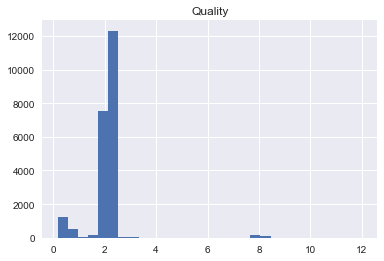

In [16]:
plt.hist(qual_all["value"], 30)
plt.title("Quality")
plt.show()

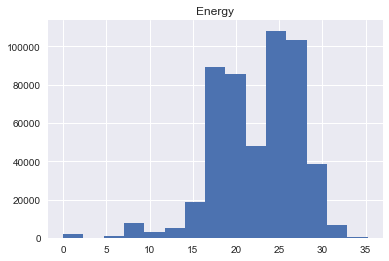

In [17]:
plt.hist(energy_all["value"], 15)
plt.title("Energy")
plt.show()

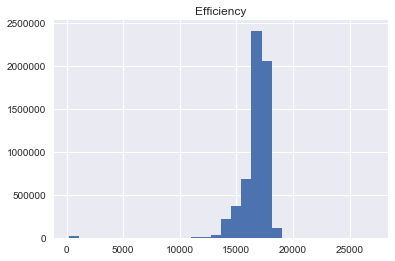

In [18]:
plt.hist(eff_all["value"], 30)
plt.title("Efficiency")
plt.show()

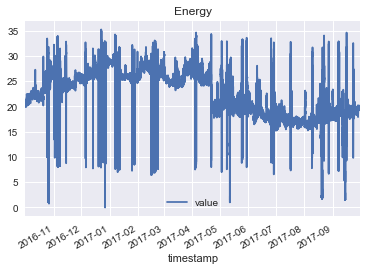

In [19]:
energy_all.plot(x = 'timestamp', y = 'value')
plt.title("Energy")

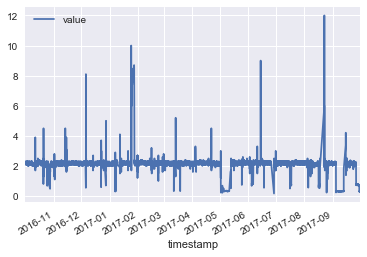

In [20]:
qual_all.plot(x = 'timestamp', y = 'value')

In [ ]:
eff_all.plot(x = 'timestamp', y = 'value')
plt.title("Efficiency")

In [ ]:
qual_lol = qual_all[qual_all['timestamp'] > '2017-09-01T12:00:00.000000000']
qual_lol = qual_lol[qual_lol['timestamp'] < '2017-10-01T18:30:00.000000000']
qual_lol.plot(x = 'timestamp', y = 'value')

In [ ]:
eff_new = pd.DataFrame()
eff_new['timestamp'] = eff_all.groupby("timestamp").value.mean().index
eff_new['value'] = eff_all.groupby("timestamp").value.mean().values
eff_new['day'] = (eff_new['timestamp'].values).astype('datetime64[D]').astype(int)-np.datetime64('2016-10-01').astype('datetime64[D]').astype(int)

eff_lag_1 = eff_new[eff_new['value'] > 0]
eff_lag_1['value'] = np.array([cut_eff(x) for x in eff_new_lol['value'].values])

eff_lag_1 = eff_lag_1[eff_lag_1['day'] != 364]
#don't use first date
eff_new = eff_new[eff_new['day'] > 0]
eff_new['day'] += -1

mean = eff_lag_1.groupby("day").value.mean() 
df = pd.DataFrame({'mean_value': mean, 'day': eff_new['day'].unique()}) 
eff_new = pd.merge(eff_new, df, how = 'left', on = 'day') 
eff_new.head()

In [ ]:
eff_new.plot(x = 'timestamp', y = ['value', 'mean_value'])
plt.show()

In [ ]:
qual_new = pd.DataFrame()
qual_new['timestamp'] = qual_all.groupby("timestamp").value.mean().index
qual_new['value'] = qual_all.groupby("timestamp").value.mean().values
qual_new['day'] = (qual_new['timestamp'].values).astype('datetime64[D]').astype(int)-np.datetime64('2016-10-01').astype('datetime64[D]').astype(int)

qual_lag_1 = qual_new[qual_new['value'] > 0]
qual_lag_1['value'] = np.array([cut_qual(x) for x in qual_new_lol['value'].values])

qual_lag_1 = qual_lag_1[qual_lag_1['day'] != 364]
#don't use first date
qual_new = qual_new[qual_new['day'] > 0]
qual_new['day'] += -1
mean = qual_lag_1.groupby("day").value.mean() 
df = pd.DataFrame({'mean_value': mean, 'day': qual_new['day'].unique()}) 
qual_new = pd.merge(qual_new, df, how = 'left', on = 'day') 
qual_new.head()

In [ ]:
qual_new.plot(x = 'timestamp', y = ['value', 'mean_value'])
plt.show()

In [356]:
energy_new = pd.DataFrame()
energy_new['timestamp'] = energy_all.groupby("timestamp").value.mean().index
energy_new['value'] = energy_all.groupby("timestamp").value.mean().values
energy_new['day'] = (energy_new['timestamp'].values).astype('datetime64[D]').astype(int)-np.datetime64('2016-10-01').astype('datetime64[D]').astype(int)

energy_lag_1 = energy_new[energy_new['value'] > 0]
energy_lag_1['value'] = np.array([cut_energy(x) for x in energy_new_lol['value'].values])

energy_lag_1 = energy_lag_1[energy_lag_1['day'] != 364]
#don't use first date
energy_new = energy_new[energy_new['day'] > 0]
energy_new['day'] += -1
mean = energy_lag_1.groupby("day").value.mean() 
df = pd.DataFrame({'mean_value': mean, 'day': energy_new['day'].unique()}) 
energy_new = pd.merge(energy_new, df, how = 'left', on = 'day') 
energy_new.head()

C:\Users\Alex\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,timestamp,value,day,mean_value
0,2016-10-02 00:00:00,20.343477,0,20.387334
1,2016-10-02 00:01:00,20.349155,0,20.387334
2,2016-10-02 00:02:00,20.396097,0,20.387334
3,2016-10-02 00:03:00,20.223352,0,20.387334
4,2016-10-02 00:04:00,20.293682,0,20.387334


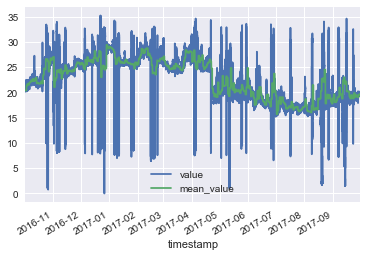

In [357]:
energy_new.plot(x = 'timestamp', y = ['value', 'mean_value'])
plt.show()

In [358]:
energy_new['diff'] = energy_new['value'] - energy_new['mean_value']
qual_new['diff'] =  qual_new['value'] - qual_new['mean_value']
eff_new['diff'] = eff_new['value'] - eff_new['mean_value']

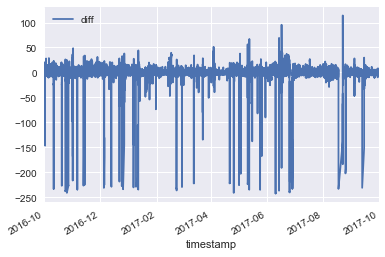

In [322]:
eff_new.plot(x = 'timestamp', y = 'diff')

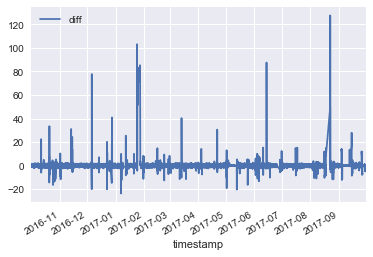

In [327]:
qual_new.plot(x = 'timestamp', y = 'diff')

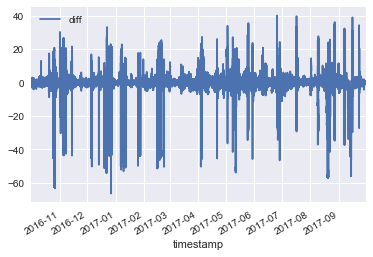

In [319]:
energy_new.plot(x = 'timestamp', y = 'diff')

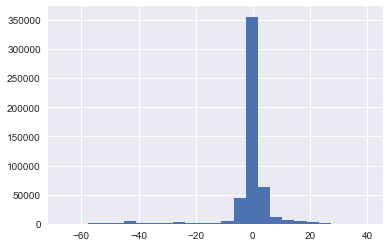

In [323]:
plt.hist(energy_new['diff'], 25)
plt.show()

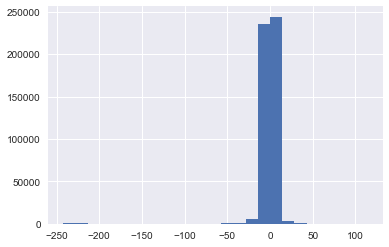

In [324]:
plt.hist(eff_new['diff'], 25)
plt.show()

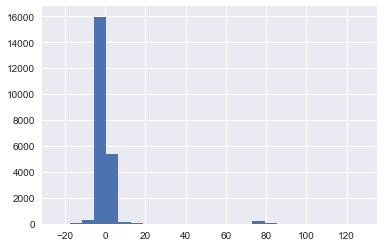

In [328]:
plt.hist(qual_new['diff'], 25)
plt.show()